<a href="https://colab.research.google.com/github/ykitaguchi77/pytorch-models/blob/master/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Google driveのデータをマウント

In [29]:
'''
フォルダ構成(※class名は4文字にすること)
---dataset.zip-----train-----appl
               |          |--stra
               |
               |---val-------appl
                          |--stra
'''


from google.colab import drive
drive.mount('/content/drive')

#dataset.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/AI_laboratory_course/dataset.zip
!date -R
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Tue, 21 Apr 2020 08:34:49 +0000
Tue, 21 Apr 2020 08:34:58 +0000
drive  sample_data  train  val


In [37]:
#データをロードする
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path= data_dir + '/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path= data_dir + '/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))

['appl', 'stra']
appl_train:252
stra_train:252
appl_val:67
stra_val:60
training data set_total：504
validating data set_total：127


#少数の画像を可視化

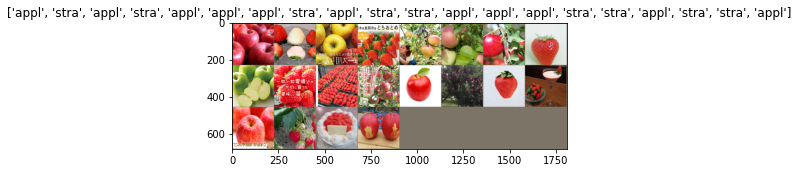

In [38]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Train models with early stopping class

In [0]:
#Defining early stopping class
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


#Train models
def train_model(model, criterion, optimizer, scheduler, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
                scheduler.step()
                print('epoch:{}, lr:{}'.format(epoch, scheduler.get_lr()[0]))
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss


#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#Define EfficientNet
※pretrained modelを用いているので、ここは不要

In [0]:
# Swish activation    
class Swish(nn.Module):                                    
    def forward(self, x):
        return x * torch.sigmoid(x)


# Squeeze Excitation module
class SEblock(nn.Module):                                 
    def __init__(self, ch_in, ch_sq):
        super(SEblock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch_in, ch_sq, 1),
            Swish(),
            nn.Conv2d(ch_sq, ch_in, 1),
        )
        self.se.apply(weights_init)

    def forward(self, x):
        return x * torch.sigmoid(self.se(x))

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)


#ConvBN module
class ConvBN(nn.Module):
    def __init__(self, ch_in, ch_out, kernel_size,
                 stride=1, padding=0, groups=1):
        super(ConvBN, self).__init__()
        self.layers = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size,
                          stride, padding, groups=groups, bias=False),
                nn.BatchNorm2d(ch_out),
        )
        self.layers.apply(weights_init)

    def forward(self, x):
        return self.layers(x)


#Drop Connect layer
class DropConnect(nn.Module):
    def __init__(self, drop_rate):
        super(DropConnect, self).__init__()
        self.drop_rate = drop_rate

    def forward(self, x):
        if self.training:
            keep_rate = 1.0 - self.drop_rate
            r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
            r += keep_rate
            mask = r.floor()
            return x.div(keep_rate) * mask
        else:
            return x


#BM module
class BMConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out,
                 expand_ratio, stride, kernel_size,
                 reduction_ratio=4, drop_connect_rate=0.2):
        super(BMConvBlock, self).__init__()
        self.use_residual = (ch_in==ch_out) & (stride==1)
        ch_med = int(ch_in * expand_ratio)
        ch_sq = max(1, ch_in//reduction_ratio)

        # define network                                                        
        if expand_ratio != 1.0:
            layers = [ConvBN(ch_in, ch_med, 1),Swish()]
        else:
            layers = []

        layers.extend([
            ConvBN(ch_med, ch_med, kernel_size, stride=stride,
                   padding=(kernel_size-1)//2, groups=ch_med), # depth-wise    
            Swish(),
            SEblock(ch_med, ch_sq), # Squeeze Excitation                        
            ConvBN(ch_med, ch_out, 1), # pixel-wise                             
        ])

        if self.use_residual:
            self.drop_connect = DropConnect(drop_connect_rate)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.drop_connect(self.layers(x))
        else:
            return self.layers(x)


#Flatten layer
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)


#EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, width_mult=1.0, depth_mult=1.0,
                 resolution=False, dropout_rate=0.2, 
                 input_ch=3, num_classes=1000):
        super(EfficientNet, self).__init__()

        # expand_ratio, channel, repeats, stride, kernel_size                   
        settings = [
            [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
            [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
            [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
            [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
            [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
            [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
            [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
        ]

        ch_out = int(math.ceil(32*width_mult))
        features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
        features.extend([ConvBN(input_ch, ch_out, 3, stride=2), Swish()])

        ch_in = ch_out
        for t, c, n, s, k in settings:
            ch_out  = int(math.ceil(c*width_mult))
            repeats = int(math.ceil(n*depth_mult))
            for i in range(repeats):
                stride = s if i==0 else 1
                features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
                ch_in = ch_out

        ch_last = int(math.ceil(1280*width_mult))
        features.extend([ConvBN(ch_in, ch_last, 1), Swish()])

        self.features = nn.Sequential(*features)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Dropout(dropout_rate))
        self.fc = nn.Linear(ch_last, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = self.fc(x)
        return x


#EfficientNetB0からB7まで
def _efficientnet(w_mult, d_mult, resolution, drop_rate,
                  input_ch, num_classes=1000):
    model = EfficientNet(w_mult, d_mult,
                         resolution, drop_rate,
                         input_ch, num_classes)
    return model


def efficientnet_b0(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.0, 1.0, 224, 0.2)              
    return _efficientnet(1.0, 1.0, None, 0.2, input_ch, num_classes)

def efficientnet_b1(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.0, 1.1, 240, 0.2)              
    return _efficientnet(1.0, 1.1, None, 0.2, input_ch, num_classes)

def efficientnet_b2(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.1, 1.2, 260, 0.3)              
    return _efficientnet(1.1, 1.2, None, 0.3, input_ch, num_classes)

def efficientnet_b3(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.2, 1.4, 300, 0.3)              
    return _efficientnet(1.2, 1.4, None, 0.3, input_ch, num_classes)

def efficientnet_b4(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.4, 1.8, 380, 0.4)              
    return _efficientnet(1.4, 1.8, None, 0.4, input_ch, num_classes)

def efficientnet_b5(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.6, 2.2, 456, 0.4)              
    return _efficientnet(1.6, 2.2, None, 0.4, input_ch, num_classes)

def efficientnet_b6(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.8, 2.6, 528, 0.5)              
    return _efficientnet(1.8, 2.6, None, 0.5, input_ch, num_classes)

def efficientnet_b7(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (2.0, 3.1, 600, 0.5)              
    return _efficientnet(2.0, 3.1, None, 0.5, input_ch, num_classes)


#Convnetを再調整する

In [97]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet 

model_ft = EfficientNet.from_pretrained('efficientnet-b3')
num_ftrs = model_ft._fc.in_features
model_ft._fc = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[7, 12, 20], gamma=0.1)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


#訓練と評価

In [95]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, patience=5, num_epochs=25)

Epoch 0/24
----------
epoch:0, lr:0.01
train Loss: 0.3364 Acc: 0.8472
val Loss: 0.0425 Acc: 0.9921
Validation loss decreased (inf --> 0.042480).  Saving model ...

Epoch 1/24
----------
epoch:1, lr:0.01
train Loss: 0.0933 Acc: 0.9702
val Loss: 0.0239 Acc: 0.9921
Validation loss decreased (0.042480 --> 0.023876).  Saving model ...

Epoch 2/24
----------
epoch:2, lr:0.01
train Loss: 0.0612 Acc: 0.9782
val Loss: 0.0208 Acc: 0.9921
Validation loss decreased (0.023876 --> 0.020781).  Saving model ...

Epoch 3/24
----------
epoch:3, lr:0.01
train Loss: 0.0564 Acc: 0.9881
val Loss: 0.0281 Acc: 0.9921
EarlyStopping counter: 1 out of 5

Epoch 4/24
----------
epoch:4, lr:0.01
train Loss: 0.0356 Acc: 0.9921
val Loss: 0.0387 Acc: 0.9921
EarlyStopping counter: 2 out of 5

Epoch 5/24
----------
epoch:5, lr:0.01
train Loss: 0.0390 Acc: 0.9940
val Loss: 0.0230 Acc: 0.9921
EarlyStopping counter: 3 out of 5

Epoch 6/24
----------
epoch:6, lr:0.0001
train Loss: 0.0143 Acc: 1.0000
val Loss: 0.0232 Acc: 0.

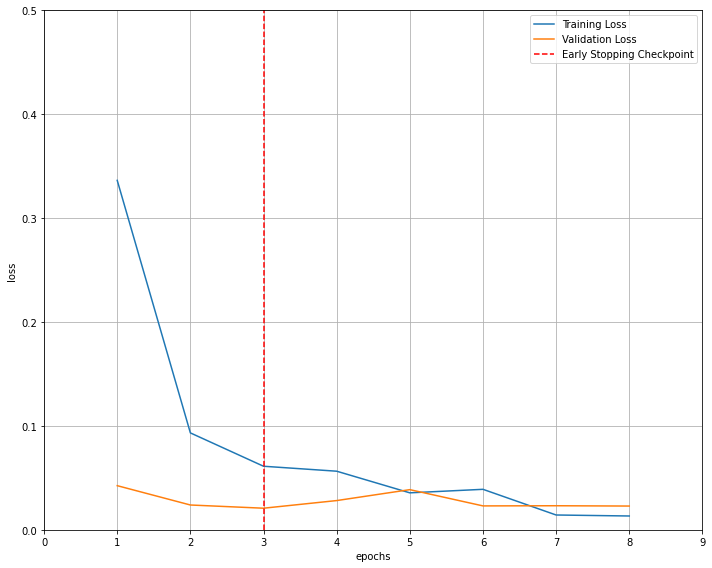

In [96]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')